In [1]:
import os

import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers, models
from tensorflow.python.data.ops.dataset_ops import AUTOTUNE
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.models import Model
import numpy as np
import cv2
import time

2024-01-22 22:46:58.248331: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-22 22:46:58.516128: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-22 22:46:58.516150: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-22 22:46:58.517378: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-22 22:46:58.630851: I tensorflow/core/platform/cpu_feature_g

In [2]:
WORKING_DIR = "/mnt/c/Users/2002j/Desktop/pliki/Uni/sem5/CV/project3/data"

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, enable=True)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-01-22 22:47:01.935612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 22:47:01.958621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 22:47:01.958664: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [4]:
images = os.listdir(WORKING_DIR)
train_images = images[-500:]

In [5]:
image_size = (256, 256)
sample_img = tf.io.read_file(f"{WORKING_DIR}/{train_images[0]}")
sample_img = tf.io.decode_png(sample_img)
print(sample_img.shape)

2024-01-22 22:47:02.141570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 22:47:02.141612: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 22:47:02.141621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 22:47:02.512115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 22:47:02.512147: I tensorflow/compile

(500, 500, 3)


mmon_runtime/gpu/gpu_device.cc:1977] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-01-22 22:47:02.512167: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-22 22:47:02.512180: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9572 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:01:00.0, compute capability: 8.9


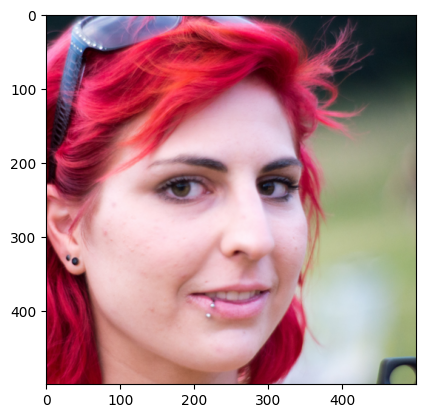

In [6]:
plt.figure()
plt.imshow(sample_img)

In [7]:
images = []

for file in train_images:
    img = cv2.imread(f"{WORKING_DIR}/{file}")
    img = cv2.resize(img, image_size)
    if img is None:
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img)

X = np.array(images) / 255.0

In [8]:
def destory_patches(image):
    augmented_img = image.copy()
    for _ in range(np.random.randint(10, 40)):
        patch_size_x = np.random.randint(5, 10)
        patch_size_y = np.random.randint(5, 10)
        x = np.random.randint(1, image.shape[1] - patch_size_x)
        y = np.random.randint(1, image.shape[0] - patch_size_y)
        augmented_img[y:y + patch_size_y, x:x+patch_size_x, :] = 0.0

    return augmented_img

In [9]:
destoryed_images = []

for img in X:
    destoryed_images.append(destory_patches(img))

In [10]:
X_destoryed = np.array(destoryed_images)

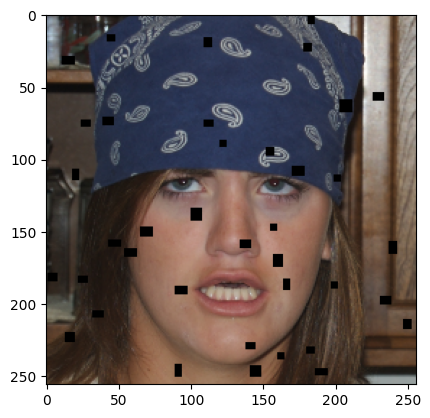

In [11]:
plt.figure()
plt.imshow(X_destoryed[196])

In [12]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4),  # (batch_size, 2, 2, 1024)
    upsample(512, 4),  # (batch_size, 4, 4, 1024)
    upsample(512, 4),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [13]:
autoencoder = Generator()
autoencoder.compile(optimizer='adam', loss='mse')

In [14]:
early = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True),
reduce = ReduceLROnPlateau(monitor='loss', patience=4),

autoencoder.fit(X_destoryed, X,
epochs=50,
batch_size=32,
shuffle=True, 
callbacks=[early, reduce])

Epoch 1/50


2024-01-22 22:47:15.399964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2024-01-22 22:47:17.569843: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2024-01-22 22:47:20.756875: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f6475a55820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-22 22:47:20.756912: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capabilit

16/16 [==============================] - 18s 417ms/step - loss: 1.0605 - lr: 0.0010
Epoch 2/50
16/16 [==============================] - 2s 116ms/step - loss: 0.6340 - lr: 0.0010
Epoch 3/50
16/16 [==============================] - 2s 115ms/step - loss: 0.5827 - lr: 0.0010
Epoch 4/50
16/16 [==============================] - 2s 113ms/step - loss: 0.5588 - lr: 0.0010
Epoch 5/50
16/16 [==============================] - 2s 116ms/step - loss: 0.5516 - lr: 0.0010
Epoch 6/50
16/16 [==============================] - 2s 114ms/step - loss: 0.5470 - lr: 0.0010
Epoch 7/50
16/16 [==============================] - 2s 118ms/step - loss: 0.5436 - lr: 0.0010
Epoch 8/50
16/16 [==============================] - 2s 120ms/step - loss: 0.5412 - lr: 0.0010
Epoch 9/50
16/16 [==============================] - 2s 116ms/step - loss: 0.5397 - lr: 0.0010
Epoch 10/50
16/16 [==============================] - 2s 116ms/step - loss: 0.5382 - lr: 0.0010
Epoch 11/50
16/16 [==============================] - 2s 115ms/step - 

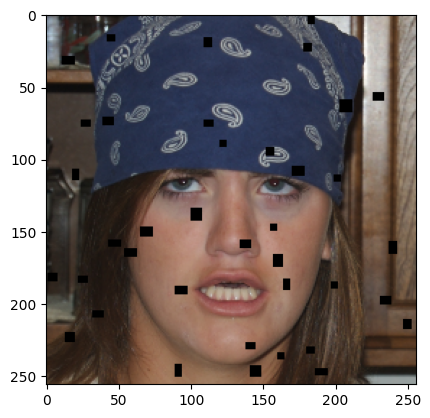

In [18]:
plt.figure()
plt.imshow(X_destoryed[196])

In [16]:
X_regenerated = autoencoder.predict(X_destoryed)

16/16 [==============================] - 2s 44ms/step


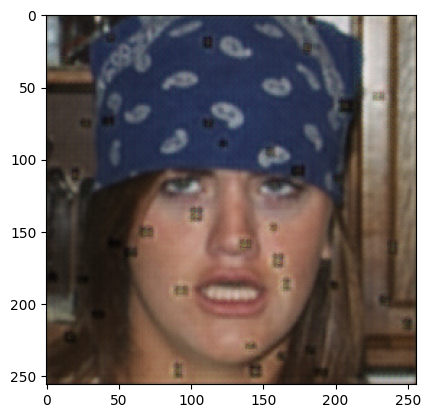

In [19]:
plt.figure()
plt.imshow(X_regenerated[196])